### IMPORT REQUIRED MODULES

In [ ]:
import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


sns.set("paper")


### LOAD MNIST

In [ ]:
def load_mnist():
    mnist = fetch_openml('mnist_784', version=1, parser='auto')
    frame = mnist['data'].assign(label=mnist['target'].astype(int))
    feats = [c for c in frame.columns if c != 'label']
    return frame, feats, 'label'

df, features, label = load_mnist()
print(df[label].value_counts().sort_index())

0    6903
1    7877
2    6990
3    7141
4    6824
5    6313
6    6876
7    7293
8    6825
9    6958
Name: label, dtype: int64


### TSNE DECOMPOSITION

In [ ]:
features_tsne = ["tsne1", "tsne2"]
tsne = TSNE(n_components=2,
            perplexity=40,
            random_state=1,
            metric = "euclidean",
            n_iter=500,
            verbose=2)

df_tsne = tsne.fit_transform(df[features])
df_tsne = pd.DataFrame(df_tsne, columns=features_tsne)
df_tsne = df_tsne.assign(label=df[label].values.astype(int))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 70000 samples in 0.494s...
[t-SNE] Computed neighbors for 70000 samples in 331.720s...
[t-SNE] Computed conditional probabilities for sample 1000 / 70000
[t-SNE] Computed conditional probabilities for sample 2000 / 70000
[t-SNE] Computed conditional probabilities for sample 3000 / 70000
[t-SNE] Computed conditional probabilities for sample 4000 / 70000
[t-SNE] Computed conditional probabilities for sample 5000 / 70000
[t-SNE] Computed conditional probabilities for sample 6000 / 70000
[t-SNE] Computed conditional probabilities for sample 7000 / 70000
[t-SNE] Computed conditional probabilities for sample 8000 / 70000
[t-SNE] Computed conditional probabilities for sample 9000 / 70000
[t-SNE] Computed conditional probabilities for sample 10000 / 70000
[t-SNE] Computed conditional probabilities for sample 11000 / 70000
[t-SNE] Computed conditional probabilities for sample 12000 / 70000
[t-SNE] Computed conditional probabilities for 

### UTIL FUNCTIONS

In [ ]:
def create_training_set(seed, random_state, unbalance_ratio=1.0):
    n1 = seed.shape[0]
    n0 = int(n1 / float(unbalance_ratio))

    rng = np.random.RandomState(seed=random_state)
    neg = 100 * rng.rand(n0, seed.shape[1]) - 50
    training_set = np.r_[
        np.c_[seed, np.ones(n1)],
        np.c_[neg, np.zeros(n0)]
    ]
    idx = np.argsort(rng.rand(training_set.shape[0]))
    training_set = training_set[idx, :]
    X, y = training_set[:, :-1], training_set[:, -1]
    return X, y


def get_pool_seed(X, labels, seed_size, seed_target, random_state):
    labels_bin = (labels == seed_target).astype(int)
    target_index = np.where(labels_bin == 1)[0]
    rng = np.random.RandomState(seed=random_state)
    seed_index = rng.choice(target_index, seed_size, replace=False)
    pool_index = np.setdiff1d(np.arange(X.shape[0]), seed_index)
    pool_labels = labels_bin[pool_index]
    seed = X[seed_index, :]
    pool = X[pool_index, :]
    return pool, seed, pool_labels


def get_classifier(n_estimators=250, random_state=None) -> Pipeline:
    steps = [
        ('StandardScaler', StandardScaler()),
        ('ExtraTreesClassifier', ExtraTreesClassifier(
            n_estimators=n_estimators, random_state=random_state)
        )
    ]
    return Pipeline(steps)


def get_scores(X, labels, seed_size, seed_target, random_state, unbalance_ratio=1.0):
    pool, seed, pool_labels = get_pool_seed(X, labels, seed_size, seed_target, random_state)
    X, y = create_training_set(seed, random_state, unbalance_ratio=unbalance_ratio)
    clf = get_classifier(random_state=random_state)
    clf.fit(X, y)
    scores = clf.predict_proba(pool)[:, 1]
    return scores, pool, seed, pool_labels, clf

def precision_recall_at_k(pool_labels, scores, k):
    scoring_index = np.argsort(-scores)
    top_k = scoring_index[:k]
    true_audience = np.where(pool_labels == 1)[0]
    size_of_intersection = np.in1d(true_audience, top_k).sum()
    precision = size_of_intersection / float(k)
    recall = size_of_intersection / float(true_audience.shape[0])
    return precision, recall


### RUN CLASSIFICATION EXPERIMENT

In [ ]:
random_states = [
    249, 660, 316, 937,  31, 196, 817, 576, 143, 524, 503, 329, 741,
    312, 159, 443, 173, 922, 452, 987, 432, 471, 337, 310, 898, 576,
    338, 644, 377, 635
]
k = 7000
seed_audience_size = 250
digits_list = sorted(df_tsne[label].unique())
results = []
for digit in digits_list:
    print(f"Processing digit {digit}")
    for rs in random_states:
        scores, _, _, pool_labels, _ = get_scores(df_tsne[features_tsne].values,
                                                  df_tsne[label].values,
                                                  seed_audience_size, digit, rs)
        pre_k, rec_k = precision_recall_at_k(pool_labels, scores, k)
        results.append({"digit": digit, "random_state": rs, "k": k,
                        "P@k": pre_k, "R@k": rec_k})
print("Complete.")

Processing digit 0
Processing digit 1
Processing digit 2
Processing digit 3
Processing digit 4
Processing digit 5
Processing digit 6
Processing digit 7
Processing digit 8
Processing digit 9
Complete.


### SUMMARY

In [ ]:
means = pd.DataFrame(results).groupby("digit")[["P@k", "R@k"]].mean()
overall = means.mean()
display(means.round(2))
display(overall.round(2))

,P@k,R@k
digit,,
0,0.93,0.98
1,0.96,0.88
2,0.90,0.93
3,0.89,0.91
4,0.88,0.93
5,0.82,0.95
6,0.92,0.97
7,0.92,0.91
8,0.85,0.90


P@k    0.90
R@k    0.93
dtype: float64

### PLOTTINGS

In [ ]:
def clear_ax(ax):
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.axis('off')


def set_axis_limits(ax):
    ax.set_xlim(left=-54, right=52)
    ax.set_ylim(bottom=-51, top=51)


def plot_decision_boundary(X, ax, clf, grid_size: float = 0.5, **kwargs):
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_size), np.arange(y_min, y_max, grid_size))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    z = z.reshape(xx.shape)
    ax.contour(xx, yy, z, colors='green', linewidths=0.2, **kwargs)

def plot_scatter(X, y, palette, ax, s=3, linewidth=0, **kwargs):
    sns.scatterplot(
        x=features_tsne[0],
        y=features_tsne[1],
        hue='label',
        palette=palette,
        data=pd.DataFrame(X, columns=features_tsne).assign(label=y),
        legend=None,
        s=s,
        ax=ax,
        linewidth=linewidth,
        **kwargs
    )
    clear_ax(ax)
    set_axis_limits(ax)


def plot_embedding():
    fig, ax = plt.subplots()
    plot_scatter(df_tsne[features_tsne].values,
                 df_tsne[label].values,
                 sns.color_palette("hls", 10), ax)
    coords = df_tsne.groupby("label", as_index=False)[features_tsne].mean()
    for dct in coords.to_dict(orient="records"):
        x, y, digit = dct[features_tsne[0]], dct[features_tsne[1]], dct[label]
        ax.text(x, y, str(digit),
                color='black',
                fontdict={'weight': 'bold', 'size': 16})
    clear_ax(ax)
    set_axis_limits(ax)
    return ax


#### Plot a sample of digits

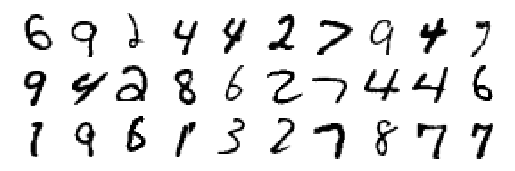

In [ ]:
rng = np.random.RandomState(seed=1)
fig, axes = plt.subplots(ncols=10,
                         nrows=3,
                         gridspec_kw = {'wspace': 0, 'hspace': -.81})
norm = df[features].max().max()
for ax in axes.ravel():
    pixels = df[features].sample(random_state=rng).values.reshape((28,28)) / norm
    ax.matshow(1 - pixels, cmap="gray")
    clear_ax(ax)

#### PLot TSNE embeddings

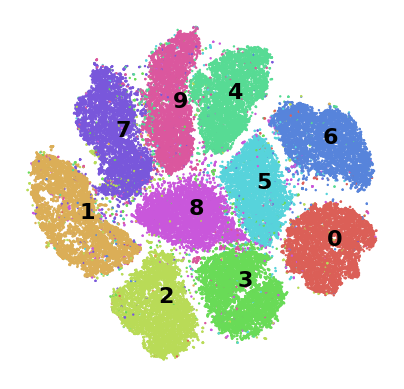

In [ ]:
ax = plot_embedding()

#### Plot training set

array([6.4, 4.8])

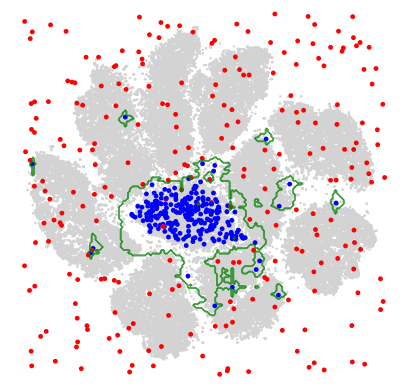

In [ ]:
digit = 8
scores, pool, seed, pool_labels, clf = get_scores(df_tsne[features_tsne].values,
                                                  df_tsne[label].values,
                                                  seed_audience_size, digit, 1)

X, y = create_training_set(seed, 1)

fig, ax = plt.subplots()

palette = sns.set_palette(sns.color_palette(["lightgray"]))
plot_scatter(df_tsne[features_tsne].values, np.zeros(len(df_tsne)), palette, ax)

palette = sns.set_palette(sns.color_palette(["red", "blue"]))
plot_scatter(X, y, palette, ax, s=12)
plot_decision_boundary(pool, ax, clf)
fig.get_size_inches()

#### Plot expanded audience

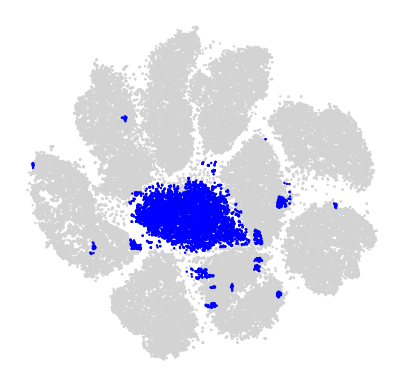

In [ ]:
digit = 8
scores, pool, seed, pool_labels, clf = get_scores(df_tsne[features_tsne].values,
                                                  df_tsne[label].values,
                                                  seed_audience_size, digit, 1)

fig, ax = plt.subplots()
palette = sns.set_palette(sns.color_palette(["lightgray"]))
plot_scatter(df_tsne[features_tsne].values, np.zeros(len(df_tsne)), palette, ax)

palette = sns.set_palette(sns.color_palette(["blue"]))
top_k = np.argsort(-scores)[:7000]
x = pool[top_k, :]
y = np.ones(len(top_k))
plot_scatter(x, y, palette, ax)


#### Plot training set for digits 6 and 8

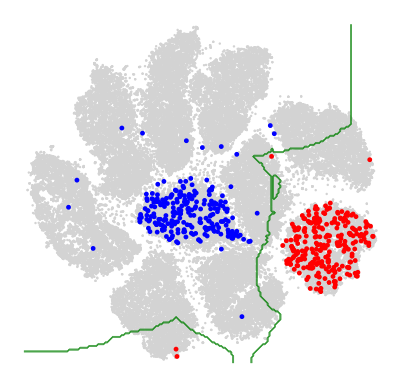

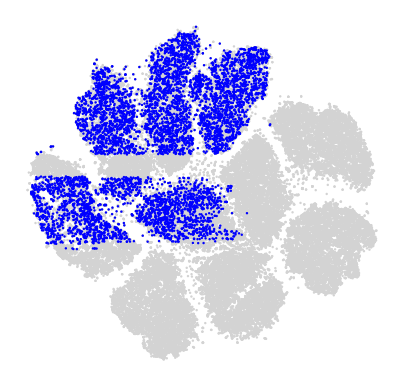

In [ ]:
class_0, class_1 = 0, 8
mask = df_tsne[label].isin([class_0, class_1])
train_idx = df_tsne[mask].sample(500, random_state=1).index
X_train = df_tsne.loc[train_idx, features_tsne].values
y_train = df_tsne.loc[train_idx, label].apply(lambda u: 1 if u == class_1 else 0).values

clf = get_classifier(n_estimators=250, random_state=1)
clf.fit(X_train, y_train)

fig, ax = plt.subplots()
palette = sns.set_palette(sns.color_palette(["lightgray"]))
plot_scatter(df_tsne[features_tsne].values, np.zeros(len(df_tsne)), palette, ax)
palette = sns.set_palette(sns.color_palette(["red", "blue"]))
plot_scatter(X_train, y_train, palette, ax, s=12)
plot_decision_boundary(pool, ax, clf)

X_test = df_tsne.loc[df_tsne.index.difference(train_idx)][features_tsne].values
scores = clf.predict_proba(X_test)[:, 1]
top_k = np.argsort(-scores)[:7000]
x = X_test[top_k, :]
y = np.ones(len(top_k))

fig, ax = plt.subplots()
palette = sns.set_palette(sns.color_palette(["lightgray"]))
plot_scatter(df_tsne[features_tsne].values, np.zeros(len(df_tsne)), palette, ax)

palette = sns.set_palette(sns.color_palette(["blue"]))
# palette = sns.color_palette("viridis", len(set(y)), as_cmap=True)
plot_scatter(x, y, palette, ax)


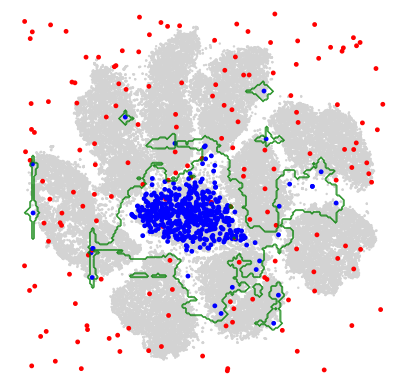

In [ ]:
digit = 8
scores, pool, seed, pool_labels, clf = get_scores(df_tsne[features_tsne].values,
                                                  df_tsne[label].values,
                                                  2 * seed_audience_size, digit,
                                                  1,
                                                  unbalance_ratio=3)

X, y = create_training_set(seed, 1, unbalance_ratio=3)

fig, ax = plt.subplots()

palette = sns.set_palette(sns.color_palette(["lightgray"]))
plot_scatter(df_tsne[features_tsne].values, np.zeros(len(df_tsne)), palette, ax)

palette = sns.set_palette(sns.color_palette(["red", "blue"]))
plot_scatter(X, y, palette, ax, s=12)
plot_decision_boundary(pool, ax, clf)
